<a href="https://colab.research.google.com/github/MarcAssmann/morse_training/blob/main/train_morse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorflow Model to train Morse discriminator** 
22/05/20



In [2]:
!git clone https://github.com/MarcAssmann/morse_training.git

fatal: destination path 'morse_training' already exists and is not an empty directory.


In [76]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

(1) Process Data from Morse Generator

In [6]:
file = 'morse_training/platformio-device-monitor-210516-161118-cleaned.log'
pd.read_csv(file)

,R,G,B,Character
0,0,0,0,
1,39,38,30,
2,39,38,30,
3,39,38,30,
4,39,38,30,
...,...,...,...,...
79797,143,148,163,N
79798,143,130,102,N
79799,143,129,96,N
79800,144,149,163,N


In [7]:
data = pd.read_csv(file)
X = data[['B']]
y = data[['Character']]
y = y.replace(' ', '_')

In [19]:
y['Character'][1]

'_'

In [8]:
# taken from https://stackoverflow.com/questions/43618245/how-to-one-hot-encode-sentences-at-the-character-level
def one_hot(c: str):
  idxs = np.fromstring(c, dtype=np.uint8) - ord('A')
  one_hot = tf.one_hot(idxs, 31, dtype=tf.uint8)
  one_hot = one_hot.numpy().tolist()[0]
  return one_hot

one_hot_mapping = {}

for i in range(ord('A'),ord('_')+1):
  c = chr(i)
  one_hot_mapping[c] = one_hot(c)

y_irgendwas = [ one_hot_mapping[c] for c in y['Character']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
one_hot_mapping["_"]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

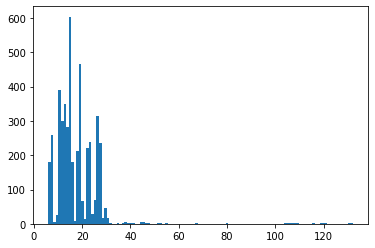

In [47]:
# Only keep sequences smaller 30 (try to throw away double characters)
last_character = y_irgendwas[0]
single_sequence = []

X_data = []
y_data = []

for i in range(len(y_irgendwas)):
  # if y_irgendwas[i] != one_hot_mapping["_"]:

  if y_irgendwas[i] == last_character:
    single_sequence.append(X['B'][i])

  else:
    if single_sequence:
      X_data.append(single_sequence)
      y_data.append(last_character)
    
    single_sequence = [X['B'][i]]
  
  last_character = y_irgendwas[i]

len(X_data), len(y_data)
plt.hist(list(map(len, X_data)), bins= 120)

mask = [ key for key,val in enumerate(X_data) if len(val)<30 ]  

y_data = [ y_data[val] for val in mask]
X_data = [ X_data[val] for val in mask]

In [56]:
# padde X_data sequences

def pad_sequence(sequence, pad_length = 30):
  if len(sequence) == pad_length:
    return sequence
  if len(sequence) > pad_length:
    return sequence[:pad_length]
  else:
    return sequence + [0]*(pad_length-len(sequence))

X_data = [ pad_sequence(seq) for seq in X_data]


In [98]:
X_tensor = tf.convert_to_tensor(X_data)
y_tensor = tf.convert_to_tensor(y_data)


In [102]:
length = len(X_tensor)

X_train = X_tensor[:int(0.6*length)]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_val = X_tensor[int(0.6*length):int(0.8*length)]
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

X_test = X_tensor[int(0.8*length):]
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = y_tensor[:int(0.6*length)]
y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))

y_val = y_tensor[int(0.6*length):int(0.8*length)]
y_val = np.reshape(y_val, (y_val.shape[0], 1, y_val.shape[1]))

y_test = y_tensor[int(0.8*length):]

In [103]:
print(X_train.shape, ',', X_train.ndim, ',', type(X_train))
print(y_train.shape, ',', y_train.ndim, ',', type(y_train))

(2679, 1, 30) , 3 , <class 'numpy.ndarray'>
(2679, 1, 31) , 3 , <class 'numpy.ndarray'>


(2) Create model

In [104]:
# model = keras.Sequential()
# # Add an Embedding layer expecting input vocab of size 1000, and
# # output embedding dimension of size 64.
# # model.add(layers.Embedding(input_dim=1000, output_dim=64))

# # Add a LSTM layer with 128 internal units.
# model.add(layers.LSTM(128))

# # Add a Dense layer with 10 units.
# # model.add(layers.Dense(10))

# model.summary()

In [108]:
# create the model
model = Sequential()
model.add(LSTM(units=128, input_shape=(1, 30), return_sequences=True))
model.add(Dense(31, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)
model.summary()

Epoch 1/5
42/42 [==============================] - 3s 21ms/step - loss: 2.7374 - accuracy: 0.3623 - val_loss: 1.6385 - val_accuracy: 0.6797
Epoch 2/5
42/42 [==============================] - 0s 7ms/step - loss: 1.3695 - accuracy: 0.7138 - val_loss: 1.0190 - val_accuracy: 0.8018
Epoch 3/5
42/42 [==============================] - 0s 6ms/step - loss: 0.8732 - accuracy: 0.8342 - val_loss: 0.7332 - val_accuracy: 0.8768
Epoch 4/5
42/42 [==============================] - 0s 6ms/step - loss: 0.6457 - accuracy: 0.8987 - val_loss: 0.5629 - val_accuracy: 0.9127
Epoch 5/5
42/42 [==============================] - 0s 7ms/step - loss: 0.4874 - accuracy: 0.9116 - val_loss: 0.4301 - val_accuracy: 0.9474
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1, 128)            81408     
_________________________________________________________________
dense_15 (Dense) 